In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    roc_auc_score, 
    silhouette_score
)
from sklearn.cluster import AffinityPropagation
from sklearn.feature_selection import mutual_info_classif


### 1. Load Expression Data

In [46]:
# load expression data
expression_data = pd.read_csv(r"/Users/lukeunbehagen/Desktop/Assignment 3/data_with_gene_names.tsv", sep='\t')

# load expression metadata 
metadata = pd.read_csv(r"/Users/lukeunbehagen/Desktop/Assignment 3/metadata_SRP092257.tsv", sep='\t')

# check size and shape of expression matrix
num_genes, num_samples = expression_data.shape
print(f"The expression matrix has {num_genes} genes and {num_samples - 1} samples.")

# ensure Ensembl IDs are strings and remove any version numbers (if present)
expression_data['Gene'] = expression_data['Gene'].astype(str).str.split('.').str[0]

The expression matrix has 23870 genes and 94 samples.


### 2. a) Subset of 5,000 

In [47]:
# calculate variance for each gene (don't include gene name column)
gene_variances = expression_data.drop(columns=['Gene']).var(axis=1)

# 5,000 most variable genes
top_5000_genes = expression_data.iloc[gene_variances.nlargest(5000).index]

# confirm subset data shape
print(f"Top 5000 variable gene data shape: {top_5000_genes.shape}")

Top 5000 variable gene data shape: (5000, 95)


### 2. b-f Method: Naïve Bayes

In [48]:
# Map 'thermoneutral' to 0 and 'Heat' to 1
metadata['condition'] = metadata['refinebio_title'].apply(
    lambda x: 0 if 'thermoneutral' in x else (1 if 'Heat' in x else np.nan)
)

# takes away the rows with NaN values in 'condition'
metadata = metadata.dropna(subset=['condition'])

# 'condition' converted to integer after removing NaNs
metadata['condition'] = metadata['condition'].astype(int)

# metadata and expression data alignment check
metadata = metadata.set_index('refinebio_accession_code')
expression_data_filtered = top_5000_genes.drop(columns=['Gene']).T
expression_data_filtered = expression_data_filtered.loc[metadata.index]

# checks the alignment
print(f"Filtered expression data shape: {expression_data_filtered.shape}")
print(f"Filtered metadata shape: {metadata.shape}")

# defines the features and labels
labels = metadata['condition']

# splits the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    expression_data_filtered, labels, test_size=0.2, random_state=42
)

# Check shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Filtered expression data shape: (44, 5000)
Filtered metadata shape: (44, 24)
Training data shape: (35, 5000)
Test data shape: (9, 5000)
Training labels shape: (35,)
Test labels shape: (9,)


Train Naiive Bayes Model

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Naiive bayes classifier
nb_model = GaussianNB()

# training of the model on the training data
nb_model.fit(X_train, y_train)

#  predictions on the test data
y_pred = nb_model.predict(X_test)
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]  

accuracy = accuracy_score(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_text)
print(f"AUC Score: {auc_score}")


Naïve Bayes model training complete.
Accuracy: 0.5789473684210527
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19

AUC Score: 0.5777777777777778


### Get the Accuracy of the Naiive Bayes model and evaluate its performance

In [33]:
from sklearn.metrics import accuracy_score, classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

# accuracy calculation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19

Accuracy: 0.5789


### Retrain Model (From Assignment 3) I Used Affinity Propagation

In [34]:
# clustering samples (genes as columns, samples as rows)
top_5000_gene_data = top_5000_genes.drop(columns=['Gene']).T

print("Running Affinity Propagation Clustering...")
clustering = AffinityPropagation(random_state=42)
labels_affinity = clustering.fit_predict(top_5000_gene_data)

# calculation of silhouette score for cluster evaluation
silhouette_avg = silhouette_score(top_5000_gene_data, labels_affinity)
print(f"Affinity Propagation Silhouette Score: {silhouette_avg}")
print(f"Number of clusters found: {len(set(labels_affinity))}")

# converion of clustering labels to a series to use as target labels
y = pd.Series(labels_affinity, name='Cluster_Label')

X = top_5000_gene_data

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialization of and training of bayes model 
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_pred_prob_nb = nb_model.predict_proba(X_test)[:, 1]  

#  detailed classification report and accuracy for each model
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")

prediction_matrix = pd.DataFrame({
    'Naive_Bayes': y_pred_prob_nb,
})

Running Affinity Propagation Clustering...
Affinity Propagation Silhouette Score: 0.16801255779936788
Number of clusters found: 9
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         4
           7       1.00      0.60      0.75         5
           8       0.60      1.00      0.75         3

    accuracy                           0.79        19
   macro avg       0.62      0.70      0.64        19
weighted avg       0.76      0.79      0.75        19

Naive Bayes Accuracy: 0.7895


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 3. Calculate sample-specific area under the ROC curve (AUC) across the predictive models created by each
### student on your team. To do this, generate a matrix of samples by models, where each cell is what class label
### the given model assigned to the given sample. 

In [35]:
expression_data = pd.read_csv(r"/Users/lukeunbehagen/Desktop/Assignment 3/data_with_gene_names.tsv", sep='\t')

# load expression metadata 
metadata = pd.read_csv(r"/Users/lukeunbehagen/Desktop/Assignment 3/metadata_SRP092257.tsv", sep='\t')

# calculate variance for each gene (don't include gene name column)
gene_variances = expression_data.drop(columns=['Gene']).var(axis=1)

# 5,000 most variable genes
top_5000_genes = expression_data.iloc[gene_variances.nlargest(5000).index]


metadata['condition'] = metadata['refinebio_title'].apply(
    lambda x: 0 if 'Control' in x else (1 if 'Heat' in x else np.nan)
)

# setting index in metadata to be sample IDs if needed for alignment
metadata = metadata.set_index('refinebio_accession_code')  
expression_data_filtered = top_5000_genes.drop(columns=['Gene']).T  

# filtering of the expression_data to keep only samples present in metadata
expression_data_filtered = expression_data_filtered.loc[metadata.index]


labels = metadata['condition'].astype(int)  # Ensure labels are integers

# Step 4: Split the Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    expression_data_filtered, labels, test_size=0.2, random_state=42
)

# Initialize Naïve Bayes classifier
nb_model = GaussianNB()

# train model on the training data
nb_model.fit(X_train, y_train)

#  predictions on the test data
y_pred = nb_model.predict(X_test)
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (Heat) for AUC calculation

# examine the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_text = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_text)
print(f"AUC Score: {auc_score}")

prediction_results = pd.DataFrame({
    'refinebio_accession_code': X_test.index,
    'Predicted_Label': y_pred
})

prediction_results.to_csv('sample_predictions.csv', index=False)
print("\nGenerated CSV file 'sample_predictions.csv' with sample predictions.")

Naïve Bayes model training complete.
Accuracy: 0.631578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19

AUC Score: 0.6055555555555556

Generated CSV file 'sample_predictions.csv' with sample predictions.


The Naiive Bayes model that I chose achieved an accuracy of 63.16% with an AUC score of 0.61, indicating moderate performance. Class 0 (thermoneutral) showed slightly better precision (64%) and recall (70%) compared to Class 1 (heat), which had precision and recall of 62% and 56%, respectively. Overall, the model's performance is decent but I did notice that other members of my group had better performing models including Harry who used Random Forest. 








In [40]:
sample_model_matrix = pd.DataFrame({
    'Naive_Bayes_Model_Luke': y_pred,
}, index=X_test.index)

combined_predictions = pd.read_csv("/Users/lukeunbehagen/Downloads/combined_predictions.csv")
combined_predictions.columns = combined_predictions.columns.str.strip()
combined_predictions = combined_predictions.set_index('refinebio_accession_code')
combined_predictions_aligned = combined_predictions.reindex(sample_model_matrix.index)

sample_model_matrix['Random_Forest_Model_Harry'] = combined_predictions_aligned['Random_Forest_Model_Harry']
sample_model_matrix['Logistic_Regression_Model_Jacob'] = combined_predictions_aligned['Logistic_Regression_Model_Jacob']
sample_model_matrix['K_Nearest_Model_Ryan'] = combined_predictions_aligned['K_Nearest_Model_Ryan']

sample_model_matrix['True_Class_Label'] = y_test

# shows the resulting matrix with labels
print("Clustering Labels Key:\n1 = Heat Affected Samples\n0 = Thermoneutral (Control Samples)")
print("\nSample Matrix with Predictions:")
display(sample_model_matrix)


Clustering Labels Key:
1 = Heat Affected Samples
0 = Thermoneutral (Control Samples)

Sample Matrix with Predictions:


,Naive_Bayes_Model_Luke,Random_Forest_Model_Harry,Logistic_Regression_Model_Jacob,K_Nearest_Model_Ryan,True_Class_Label
SRR4478687,1,1,1,1,1
SRR4478668,1,1,1,1,1
SRR4478702,1,0,0,0,0
SRR4478720,0,1,1,0,1
SRR4478643,0,0,0,0,0
SRR4478672,0,0,0,1,1
SRR4478686,1,0,1,0,0
SRR4478715,0,0,0,1,0
SRR4478654,1,0,0,1,0
SRR4478691,0,0,0,0,0


The table compares predictions from our groups four models (Random Forest, Naive Bayes, Logistic Regression, and K-Nearest Neighbors) against true class labels. Random Forest and Naive Bayes predicted identically and performed well on true positives but misclassified some true negatives. Logistic Regression and K-Nearest Neighbors showed more variation, with notable misclassifications like SRR4478720 and SRR4478654. Random Forest and Naive Bayes aligned closely, while Logistic Regression and K-Nearest Neighbors differed more.








### Analysis of Model Predictions and Cluster Stability

#### a. How many models predict each class label for each sample?
The **Class label counts** matrix shows the number of models predicting each class label for each sample. Here’s a summary based on the data:

- **SRR4478687:** All 4 models predict class label `1`.
- **SRR4478702:** 2 models predict `1` (Random Forest, Naive Bayes), and 2 models predict `0` (Logistic Regression, K-Nearest).
- **SRR4478720:** 3 models predict `0`, and 1 model predicts `1`.
- **SRR4478656:** All 4 models predict class label `1`.

This pattern repeats across the dataset, with varying levels of agreement among models for each sample.

---

#### b. How many models predict the same cluster for each sample?
The **Same cluster count** indicates whether all models predicted the same class label (1 for agreement, 0 for disagreement). Based on the data:

- **SRR4478687, SRR4478668, SRR4478656:** All models agree on class label → Agreement (1).
- **SRR4478702, SRR4478720:** Models do not fully agree → Disagreement (0).

This shows that agreement varies across samples, with some having unanimous predictions and others showing disagreement among models.

---

#### c. Does the stability of the cluster and class label prediction correlate?
The stability of the cluster (agreement among model predictions) does not appear to strongly correlate with the accuracy of the predictions in this dataset. For samples where models fully agreed on the class label (e.g., SRR4478687 and SRR4478668), the predictions aligned with the true class label. However, in cases of disagreement (e.g., SRR4478702 and SRR4478686), some models still matched the true label. This variability suggests no clear pattern between agreement and prediction accuracy.


### 4. Retrain each predictive model using different numbers of genes. Try 10, 100, 1000, and 10000 genes. 

In [37]:
# select top n most variable genes
def select_top_n_genes(data, n):
    gene_variances = data.var(axis=1)
    top_n_genes_idx = gene_variances.nlargest(n).index
    return data.loc[top_n_genes_idx]

# gene sizes to test
gene_sizes = [10, 100, 1000, 10000]
results = []

# iterations over each gene subset size
for n_genes in gene_sizes:
    print(f"\nTesting with top {n_genes} genes:")
    
    # top n most variable genes and transpose for sample-based analysis
    subset_data = select_top_n_genes(expression_data.drop(columns=['Gene']), n_genes).T 
    
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(subset_data, labels, test_size=0.2, random_state=42)
    
    # train the Naiive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    y_pred_prob_nb = nb_model.predict_proba(X_test)[:, 1]  
    
    # AUC for binary classification
    auc_nb = roc_auc_score(y_test, y_pred_prob_nb)
    print(f"Naïve Bayes AUC with {n_genes} genes: {auc_nb:.4f}")
    
    #results
    results.append({'Num_Genes': n_genes, 'Naive_Bayes_AUC': auc_nb})

results_df = pd.DataFrame(results)

print("\nSummary of AUC results by gene count:")
print(results_df)



Testing with top 10 genes:
Naïve Bayes AUC with 10 genes: 0.5556

Testing with top 100 genes:
Naïve Bayes AUC with 100 genes: 0.6222

Testing with top 1000 genes:
Naïve Bayes AUC with 1000 genes: 0.6389

Testing with top 10000 genes:
Naïve Bayes AUC with 10000 genes: 0.5778

Summary of AUC results by gene count:
   Num_Genes  Naive_Bayes_AUC
0         10         0.555556
1        100         0.622222
2       1000         0.638889
3      10000         0.577778


**a. How did the number of genes affect the results?**

The number of genes included in the model had a differing impact on AUC performance. Using only 10 genes, the model had an AUC of 0.5556. Increasing the gene count to 100 improved the AUC to 0.6222, indicating that adding more features initially enhanced model performance. This trend continued with 1,000 genes, reaching the highest AUC of 0.6389. However, when the gene count was increased to 10,000, the AUC dropped to 0.5778, suggesting that too many features may introduce noise or irrelevant information. Overall, the model’s performance increased with additional genes up to 1,000, but declined when 10,000 genes were used.

**b. What is the model performance (AUC) for each of the different versions of the model? Does it increase or decrease as the number of genes included in the model changes?**

- **10 genes:** AUC = 0.5556
- **100 genes:** AUC = 0.6222
- **1,000 genes:** AUC = 0.6389
- **10,000 genes:** AUC = 0.5778

The model’s AUC performance increased with more genes, peaking at 1,000 genes, but then decreased with 10,000 genes, showing that Naïve Bayes performs best with a moderate number of features.


### 5. Heatmaps and Dendrograms

<Figure size 1200x1000 with 0 Axes>

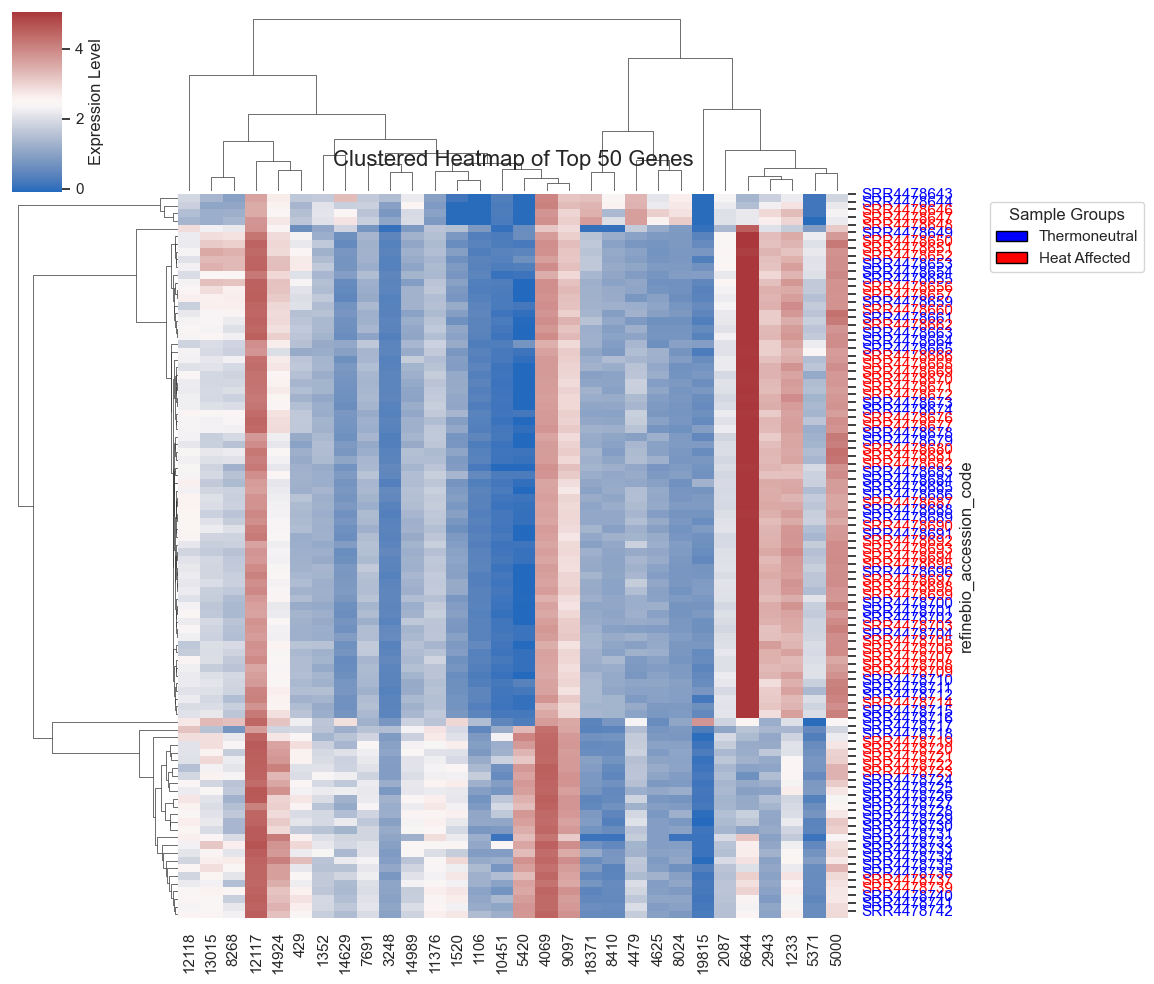

In [39]:
# mutual information scores for feature selection
feature_scores = mutual_info_classif(X_train, y_train)

# top 50 genes based on mutual information scores
top_50_indices = np.argsort(feature_scores)[-50:][::-1]
top_50_genes = X_train.columns[top_50_indices]

# the expression data for the top 50 genes
top_genes_data = expression_data_filtered[top_50_genes.intersection(expression_data_filtered.columns)]

# sample group labels from metadata
group_labels = metadata.loc[top_genes_data.index, 'condition']

# hierarchical clustering
row_clust = linkage(top_genes_data, method='average', metric='correlation')
col_clust = linkage(top_genes_data.T, method='average', metric='correlation')

# heatmap creation
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 10))

heatmap = sns.clustermap(
    data=top_genes_data,
    row_cluster=True, col_cluster=True,
    row_linkage=row_clust, col_linkage=col_clust,
    cmap="vlag",
    xticklabels=True, yticklabels=True,  # Show tick labels for rows and columns
    cbar_kws={'label': 'Expression Level'},
)

heatmap.ax_heatmap.set_yticks(np.arange(len(top_genes_data.index)))
heatmap.ax_heatmap.set_yticklabels(top_genes_data.index)

sample_colors = group_labels.map({0: 'blue', 1: 'red'}).values
for label, color in zip(heatmap.ax_heatmap.get_yticklabels(), sample_colors):
    label.set_color(color)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Thermoneutral'),
    Patch(facecolor='red', edgecolor='black', label='Heat Affected'),
]
heatmap.ax_heatmap.legend(
    handles=legend_elements,
    title='Sample Groups',
    bbox_to_anchor=(1.2, 1), loc='upper left'
)

# title
heatmap.ax_heatmap.set_title("Clustered Heatmap of Top 50 Genes", fontsize=16, pad=20)

plt.show()
